In [1]:
import tensorflow_hub as hub
import numpy as np
import os
import json
from sklearn.metrics.pairwise import cosine_similarity

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [4]:
from dotenv import load_dotenv
import pymongo
load_dotenv() 

True

In [7]:
client = pymongo.MongoClient(os.environ["MONGO_HOST"])
db = client["hotels"]
reviews_col = db["reviews"]
hotels_col = db["hotels"]

In [17]:
reviews = []
hotel_reviews_mapper = {}

for review_doc in reviews_col.find():
    hotel_doc = hotels_col.find_one({'location_id': str(review_doc['location_id'])})
    country = hotel_doc['address_obj']['country']
    review = review_doc['text']
    text = f'{review} {country}'
    hotel_reviews_mapper[len(reviews)] = hotel_doc
    reviews.append(text)

In [18]:
reviews[:5]

['This hotel is great if you want a good nights kip! Comfortable bed, fridge, kettle, good sized tv and the bathroom is very modern. There is also a safe in the LONG wardrobes which was great! The decor in rooms was just a bit dull (dark wood/carpets/curtains) however im more for comfort, new, fresh and clean, and it was all of these things! Staff were extremely helpful and rooms were cleaned on request.  Turkiye',
 'We loved our stay at Eden Roc - we were in one of the bungalows. It was clean and in a nice quiet location. \n\nWe stayed for a week which was probably long enough as we were able to do different activities each day. \n\nRestaurants were great, but make sure you book as soon as you arrive otherwise it can be hard to get in as they are (other than the buffet restaurant) quite small. \n\nThe buffet restaurant had a great selection for breakfast and dinner and it was good quality too. \n\nBar staff were great, really friendly and we had a great selection of drinks including p

In [30]:
def find_recommendations(reviews, user_prompts):
  reviews_embeddings_ = embed(reviews)
  reviews_embeddings_2D = np.reshape(reviews_embeddings_, (len(reviews_embeddings_), -1))
  prompts_embedded = embed(user_prompts)
  for prompt in prompts_embedded:
    target_tensor_2D = np.reshape(prompt, (1, -1))
    similarities = cosine_similarity(target_tensor_2D, reviews_embeddings_2D)
    most_similar_index = np.argmax(similarities[0])
    hotel = hotel_reviews_mapper[most_similar_index]
    print('Hotel:', hotel['name'], hotel['location_id'])
    print('similarity', similarities[0][most_similar_index])
    print(reviews[most_similar_index])


In [31]:
user_prompts = [
  'I want to go to Turkey, near sea', 
  'Somewhere to climb mountains', 
  'Where is the best paella', 
  'I want to try surfing and eat tropical fruits', 
  'Going to exotic country'
  ]
find_recommendations(reviews, user_prompts)

Hotel: Movenpick Hotels & Resorts 301054
similarity 0.4188065
A fantastic location, great staff, a lovely sleep and scrumptious food, but sadly the Turkish economy is taking its toll on the hotel. No international charging ports, no English language programs on TV, and very few English speakers. This was a lovely stay I just with Erdogan would help his country try and people rather than himself! Turkiye
Hotel: Balcova Termal Otel 1193232
similarity 0.15361835
Best value of anyplace I've ever stayed, and I've travelled in 70 countries!  Nice room with balcony overlooking the forest, huge and delicious breakfast, use of the beautiful spa and grounds, and nearby hiking trails.  Was so great I decided to spend a whole month here!   Turkiye
Hotel: Leonardo Royal Hotel Barcelona Fira 21504483
similarity 0.43521333
Very very good. Clean. Friendly staff. Good breakfast. 
I wish restourant meniu is better so I would eat here offten. I wish they have ice tapas and more main course dishes for eve

## Results review

Movenpick Hotels & Resorts is hotel in Turkey near sea https://www.tripadvisor.com/Hotel_Review-g298006-d301054-Reviews-Movenpick_Hotels_Resorts-Izmir_Izmir_Province_Turkish_Aegean_Coast.html

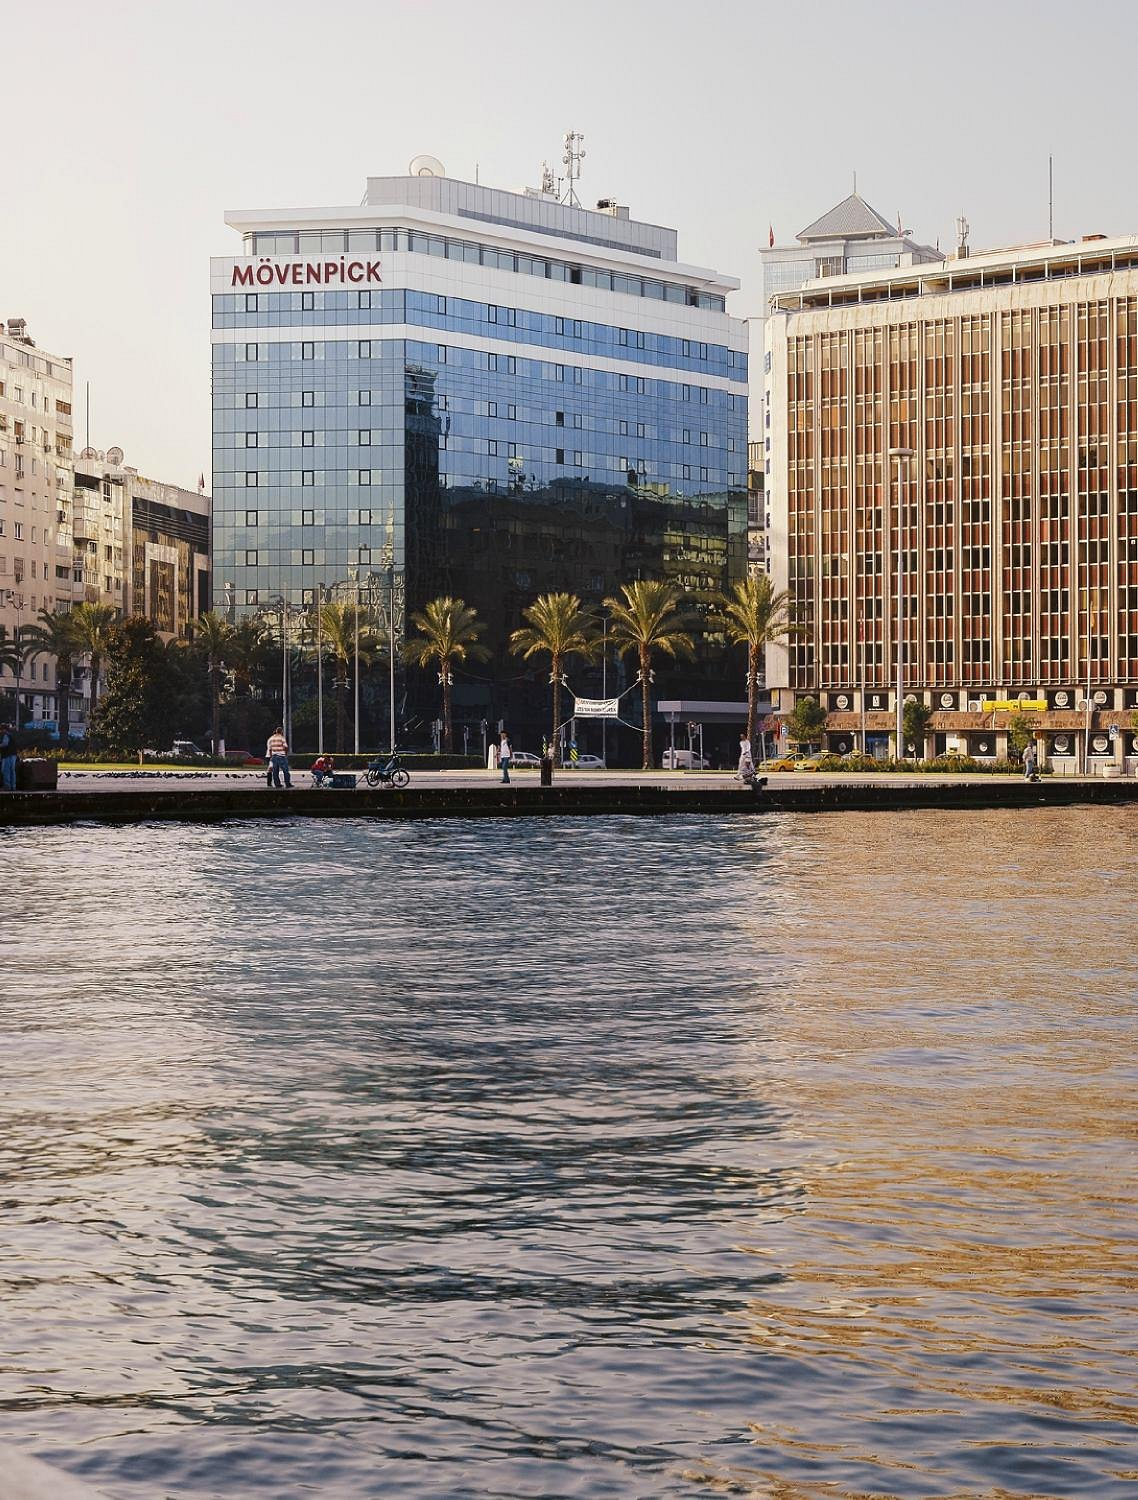

Balcova Termal Otel offers `hiking trails` and located near park with small mountains https://www.tripadvisor.com/Hotel_Review-g298006-d1193232-Reviews-Balcova_Termal_Otel-Izmir_Izmir_Province_Turkish_Aegean_Coast.html

For paella we got recommendation for Leonardo Royal Hotel Barcelona Fira in Spain. But in reviews saying that food could be better which is opposite to user prompt https://www.tripadvisor.com/Hotel_Review-g187497-d21504483-Reviews-Leonardo_Royal_Hotel_Barcelona_Fira-Barcelona_Catalonia.html

For surfing and tropical fruits we got Rehana Sharm Resort - Aquapark & Spa with `good fruits` in review and different water activities offered by hotel

As we don't have any exotic countries it dataset, for such request we got review with `Best value of anyplace I've ever stayed, and I've travelled in 70 countries!`. Where word `country` is repeated. https://www.tripadvisor.com/Hotel_Review-g298006-d1193232-Reviews-Balcova_Termal_Otel-Izmir_Izmir_Province_Turkish_Aegean_Coast.html

Overall we can see that recommendations in most cases have sense

## Recommendations based on hotel descriptions

In [32]:
hotels_folder = "./hotels/"

hotel_mapper = {}
descriptions = []
for filename in os.listdir(hotels_folder):
  if filename == '.gitkeep': continue
  hotel_json = json.load(open(hotels_folder+filename, 'r', encoding="utf8"))
  if ('description' not in hotel_json):
    continue
  hotel_mapper[len(descriptions)] = hotel_json
  descriptions.append(hotel_json['description'])

In [33]:
def find_recommendations_from_description(to_embed, user_prompts):
  embeddings_ = embed(to_embed)
  embeddings_2D = np.reshape(embeddings_, (len(embeddings_), -1))
  prompts_embedded = embed(user_prompts)
  for prompt in prompts_embedded:
    target_tensor_2D = np.reshape(prompt, (1, -1))
    similarities = cosine_similarity(target_tensor_2D, embeddings_2D)
    most_similar_index = np.argmax(similarities[0])
    hotel = hotel_mapper[most_similar_index]
    print('Hotel:', hotel['name'], hotel['location_id'])
    print('similarity', similarities[0][most_similar_index])
    print(descriptions[most_similar_index])

In [34]:
find_recommendations_from_description(descriptions, user_prompts)

Hotel: Su Hotel 295789
similarity 0.3489762
The Su Hotel Bodrum is in an intimate oasis located close to the harbour in the quieter Western Bay of Bodrum Turkey. Our hotel is close enough to walk easily to the centre of Bodrum Harbour but far enough away to ensure your stay is quiet and uninterrupted.
Hotel: Tempo Residence Comfort 1216886
similarity 0.25237444
Home away from Home
Hotel: Safestay Barcelona Passeig De Gracia 629068
similarity 0.28119516
Safestay Barcelona Passeig de Gràcia hostel is located on the most elegant avenue in Barcelona, featuring some of the best architectural walkings you will find in the city. The level of attention to detail you can find on this street is unrivalled not only in Barcelona but in any city of the world. Passeig de Gràcia is a real gem when it comes to capturing those all-important Instagram snaps!
Hotel: Dionysos Hotel 316720
similarity 0.26197538
Tropical meets Mediterranean

What if you had a choice between a getaway in the tropics with coc

https://www.tripadvisor.com/Hotel_Review-g298658-d295789-Reviews-Su_Hotel-Bodrum_City_Bodrum_District_Mugla_Province_Turkish_Aegean_Coast.html
Su Hotel in Turkey and few times in description mentioned `harbour`

Tempo Residence Comfort https://www.tripadvisor.com/Hotel_Review-g15263864-d1216886-Reviews-Tempo_Residence_Comfort-Konak_Izmir_Izmir_Province_Turkish_Aegean_Coast.html
Nothing about mountains in description, but at least you can find small mountains nearby city

For paella we got hotel in Spain Safestay Barcelona Passeig De Gracia https://www.tripadvisor.com/Hotel_Review-g187497-d629068-Reviews-Safestay_Barcelona_Passeig_De_Gracia-Barcelona_Catalonia.html

Dionysos Hotel few times mentioned tropics and has a beach suitable for surfing https://www.tripadvisor.com/Hotel_Review-g635614-d316720-Reviews-Dionysos_Hotel-Ialyssos_Rhodes_Dodecanese_South_Aegean.html

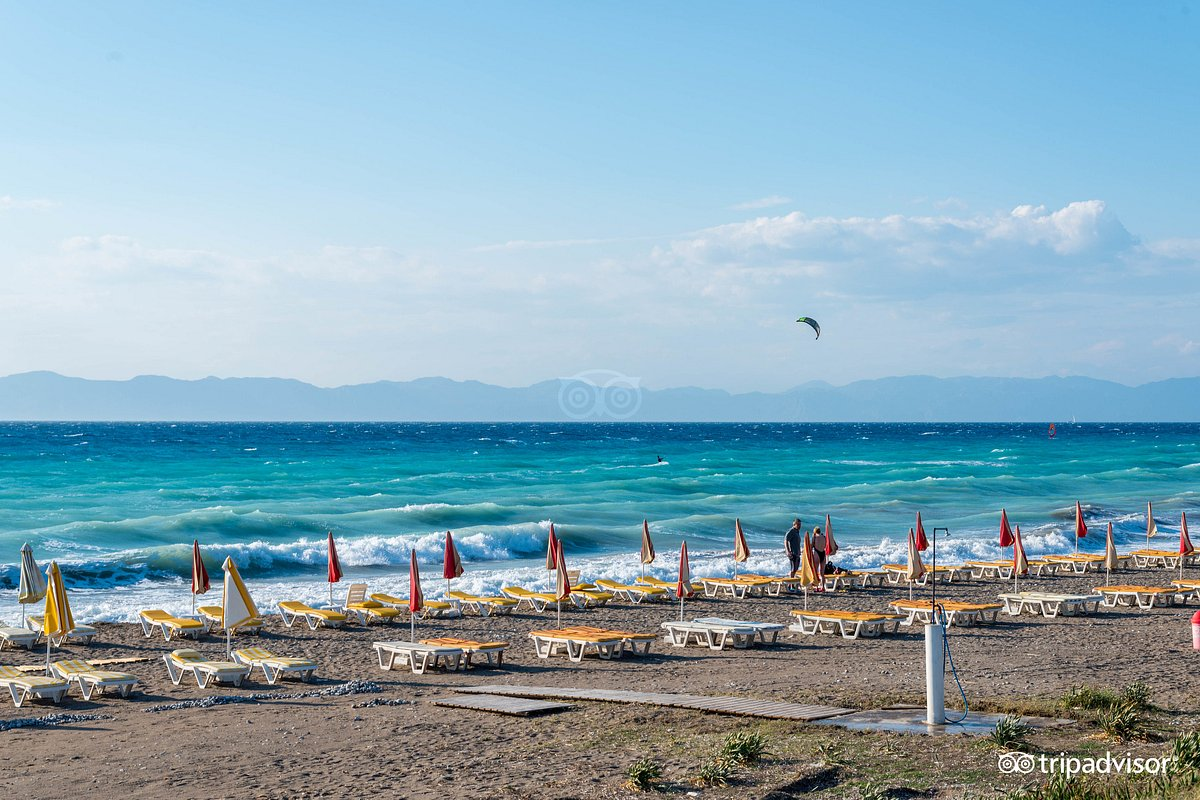

For exotics we got hotel in Dubai Bab Al Shams Desert Resort and Spa https://www.tripadvisor.com/Hotel_Review-g295424-d526588-Reviews-Bab_Al_Shams_Desert_Resort_and_Spa-Dubai_Emirate_of_Dubai.html which might be an option.

As we see getting recommendation from hotel description gives us meaningful recommendations. For future improvements we can combine this two approaches